In [1]:
# %%
# Import necessary libraries for data handling, model utilization, and visualization
import numpy as np
import pandas as pd
import yfinance as yf  # For collecting financial data
import matplotlib.pyplot as plt
from typing import List, Dict, Optional, Tuple
from datetime import datetime, timedelta
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from scipy.optimize import minimize
from collections import deque
# Import the custom Model class
from Model import Model
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s:%(message)s')

# Set the random seed for reproducibility across numpy and tensorflow
np.random.seed(123)
tf.random.set_seed(123)

plt.style.use('seaborn-darkgrid')

# Define the tickers and date range with consideration of trading days
TICKERS = ['AGG', 'DBC', 'VTI', '^VIX', 'VEA', 'EEM', 'VNQ', 'IWM']

# Approximate number of trading days per year (useful for annualizing returns)
TRADING_DAYS_PER_YEAR = 252
# Define transaction cost rate
C = 0.0001  # 0.01%

# Confirm setup
print("Setup complete: libraries imported, random seed set, and tickers defined.")

Setup complete: libraries imported, random seed set, and tickers defined.


C:\Users\wiztu\AppData\Local\Temp\ipykernel_21208\3919440199.py:27: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


In [2]:
# %%
# Data Collection Step
# Objective: Fetch historical adjusted close prices for defined tickers and date range

# Download data using yfinance for the specified tickers and date range
def get_data(tickers, start_date, end_date):
    """
    Retrieves historical adjusted close prices for the given tickers and date range.
    
    Parameters:
    - tickers: List of stock ticker symbols
    - start_date: Start date for historical data
    - end_date: End date for historical data
    
    Returns:
    - DataFrame of adjusted close prices, with each column representing a ticker
    """
    # Fetch data from yfinance
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    
    # Drop rows with missing values, if any, to ensure data continuity
    data.dropna(inplace=True)
    
    return data

# Fetch the data and display a quick preview
data = get_data(TICKERS, '2006-01-01', '2024-11-26')
print("Data fetched successfully. Sample data:")
print(data.head())

# Confirm data spans the expected range and has the expected number of columns
print(f"Data covers {len(data)} trading days with {len(data.columns)} assets.")

[*********************100%%**********************]  8 of 8 completed

Data fetched successfully. Sample data:
Ticker            AGG        DBC        EEM        IWM        VEA        VNQ  \
Date                                                                           
2007-07-26  59.407768  23.019384  31.014324  61.926193  28.500334  32.133648   
2007-07-27  59.347603  23.240469  30.612551  60.420197  28.065983  31.067537   
2007-07-30  59.317581  22.975168  31.614660  61.468853  28.536030  31.668425   
2007-07-31  59.503910  23.160881  30.967596  60.790760  28.500334  31.542431   
2007-08-01  59.365673  23.125505  30.846144  61.121929  28.619333  31.959192   

Ticker            VTI       ^VIX  
Date                              
2007-07-26  53.209721  20.740000  
2007-07-27  52.208832  24.170000  
2007-07-30  52.981224  20.870001  
2007-07-31  52.255962  23.520000  
2007-08-01  52.564194  23.670000  
Data covers 4365 trading days with 8 assets.


In [3]:
# %%
def preprocess_data(data, rolling_window=50):
    """
    Prepares data by calculating window-day rolling averages and returns.

    Parameters:
    - data: DataFrame of historical adjusted close prices for assets
    - rolling_window: Window size for the rolling average

    Returns:
    - normalized_data: Smoothed prices, normalized to start at 1 for each asset
    - returns: Smoothed returns using a rolling mean of percentage changes
    """
    # Calculate rolling mean for prices and returns to smooth the data
    smoothed_prices = (data.rolling(window=rolling_window).mean()).dropna()
    smoothed_returns = (data.pct_change().rolling(window=rolling_window).mean()).dropna()
    # Normalize prices to start each asset's time series at 1
    normalized_data = smoothed_prices / smoothed_prices.iloc[0]
    
    return normalized_data, smoothed_returns


# Run preprocessing and display sample data
normalized_data, smoothed_returns = preprocess_data(data)
print("Data preprocessing complete. Sample normalized data:")
print(normalized_data.head())
print("\nSample daily returns:")
print(smoothed_returns.head())


Data preprocessing complete. Sample normalized data:
Ticker           AGG       DBC       EEM       IWM       VEA       VNQ  \
Date                                                                     
2007-10-04  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
2007-10-05  1.000263  1.001310  1.003596  1.001472  1.001354  1.003240   
2007-10-08  1.000705  1.001988  1.007200  1.003269  1.002808  1.006693   
2007-10-09  1.001113  1.003039  1.010527  1.004901  1.004195  1.010032   
2007-10-10  1.001487  1.004174  1.014295  1.006733  1.005544  1.013292   

Ticker           VTI      ^VIX  
Date                            
2007-10-04  1.000000  1.000000  
2007-10-05  1.001164  0.996699  
2007-10-08  1.002676  0.990916  
2007-10-09  1.004046  0.986822  
2007-10-10  1.005647  0.980918  

Sample daily returns:
Ticker           AGG       DBC       EEM       IWM       VEA       VNQ  \
Date                                                                     
2007-10-05  0.000268  0.00

In [4]:
class Portfolio:
    def __init__(self, initial_cash: float, asset_names: List[str], transaction_cost: float = 0.0001):
        self.initial_cash = initial_cash
        self.current_value = initial_cash
        self.transaction_cost_rate = transaction_cost
        self.asset_names = asset_names
        self.current_weights = np.zeros(len(asset_names))
        self.portfolio_values = []
        self.weights_history = []
        self.dates = []
        self.transaction_cost = 0.0  # Initialize transaction cost

    def rebalance(self, new_weights: np.array):
        # Compute transaction costs
        if len(self.weights_history) == 0:
            transaction_cost = self.transaction_cost_rate * np.sum(np.abs(new_weights))
        else:
            transaction_cost = self.transaction_cost_rate * np.sum(np.abs(new_weights - self.current_weights))
        self.transaction_cost = transaction_cost * self.current_value
        self.current_weights = new_weights.copy()
        self.weights_history.append(self.current_weights.copy())

    def update_portfolio_value(self, asset_returns: np.array, current_date: pd.Timestamp):
        # Compute portfolio return
        portfolio_return = np.dot(self.current_weights, asset_returns)
        self.current_value = self.current_value * (1 + portfolio_return) - self.transaction_cost
        self.transaction_cost = 0.0
        self.portfolio_values.append(self.current_value)
        self.dates.append(current_date)
    
    def get_portfolio_values(self):
        return self.portfolio_values


In [5]:
# %%
def calculate_metrics(portfolio_values):
    """
    Calculates performance metrics for the portfolio.

    Parameters:
    - portfolio_values: List of daily portfolio values over the testing period.

    Returns:
    - metrics: Dictionary containing various performance metrics.
    """
    # Convert portfolio values to daily returns
    portfolio_returns = np.diff(portfolio_values) / portfolio_values[:-1]
    
    # Number of days
    N = len(portfolio_returns)

    # Calculate Sharpe Ratio
    mean_return = np.mean(portfolio_returns)
    std_dev = np.std(portfolio_returns)
    sharpe_ratio = mean_return / std_dev * np.sqrt(TRADING_DAYS_PER_YEAR)
    
    # Calculate Sortino Ratio
    downside_returns = portfolio_returns[portfolio_returns < 0]
    downside_std_dev = np.std(downside_returns) if len(downside_returns) > 0 else 0
    sortino_ratio = mean_return / downside_std_dev * np.sqrt(TRADING_DAYS_PER_YEAR) if downside_std_dev != 0 else np.nan
    
    # Calculate Maximum Drawdown
    cumulative_max = np.maximum.accumulate(portfolio_values)
    drawdowns = (cumulative_max - portfolio_values) / cumulative_max
    max_drawdown = np.max(drawdowns)
    
    # Expected return (annualized)
    cumulative_return = (portfolio_values[-1] / portfolio_values[0]) - 1
    annualized_return = (1 + cumulative_return) ** (TRADING_DAYS_PER_YEAR / N) - 1

    # Standard deviation of returns (annualized)
    annualized_std = std_dev * np.sqrt(TRADING_DAYS_PER_YEAR)

    # Percentage of positive returns
    positive_returns = portfolio_returns[portfolio_returns > 0]
    percentage_positive = len(positive_returns) / len(portfolio_returns) * 100

    # Average profit / average loss (profit/loss ratio)
    average_profit = np.mean(portfolio_returns[portfolio_returns > 0]) if len(positive_returns) > 0 else 0
    average_loss = np.mean(portfolio_returns[portfolio_returns < 0]) if len(portfolio_returns[portfolio_returns < 0]) > 0 else 0
    profit_loss_ratio = (average_profit / -average_loss) if average_loss != 0 else np.nan

    metrics = {
        "Annualized Return": annualized_return,
        "Annualized Std Dev": annualized_std,
        "Sharpe Ratio": sharpe_ratio,
        "Sortino Ratio": sortino_ratio,
        "Max Drawdown": max_drawdown,
        "% Positive Returns": percentage_positive,
        "Profit/Loss Ratio": profit_loss_ratio
    }
    
    return metrics


In [6]:
# %%
def equal_weighted_strategy(returns):
    """
    Creates an equal-weighted portfolio.

    Parameters:
    - returns: DataFrame of daily returns for each asset.

    Returns:
    - equal_weights: Numpy array of equal weights for each asset.
    """
    num_assets = returns.shape[1]
    equal_weights = np.ones(num_assets) / num_assets
    return equal_weights

# Define function to get MV weights
def mean_variance_optimized_strategy(returns):
    """
    Creates a mean-variance optimized portfolio by maximizing the Sharpe Ratio.

    Parameters:
    - returns: DataFrame of daily returns for each asset.

    Returns:
    - optimized_weights: Numpy array of optimized weights for each asset.
    """
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    
    def neg_sharpe(weights):
        portfolio_return = np.dot(weights, mean_returns)
        portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return -portfolio_return / portfolio_std

    # Constraints: Weights must sum to 1, and each weight must be between 0 and 1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(returns.shape[1]))

    result = minimize(neg_sharpe, np.ones(returns.shape[1]) / returns.shape[1], bounds=bounds, constraints=constraints)
    optimized_weights = result.x
    
    return optimized_weights

# Define function to get MD weights
def maximum_diversification(returns):
    """
    Perform maximum diversification optimization based on the given returns.

    Parameters:
    - returns: DataFrame of daily returns for each asset.

    Returns:
    - optimal_weights: Array of portfolio weights that maximize diversification.
    """
    # Calculate asset volatilities (standard deviation of each asset’s returns)
    asset_volatilities = returns.std()

    # Calculate the covariance matrix of returns
    cov_matrix = returns.cov()

    # Define the diversification ratio to be maximized
    def neg_diversification_ratio(weights):
        # Calculate the weighted average asset volatility
        weighted_volatility = np.dot(weights, asset_volatilities)
        
        # Calculate the portfolio volatility as the weighted covariance matrix
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        
        # Diversification ratio (we negate this because we want to maximize it)
        diversification_ratio = weighted_volatility / portfolio_volatility
        return -diversification_ratio  # Negate to turn this into a minimization problem

    # Constraints: weights sum to 1, and each weight between 0 and 1 (long-only portfolio)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(len(asset_volatilities)))

    # Initial guess (equal allocation)
    init_guess = np.ones(len(asset_volatilities)) / len(asset_volatilities)

    # Optimize to find weights that maximize diversification ratio
    result = minimize(neg_diversification_ratio, init_guess, bounds=bounds, constraints=constraints)
    optimal_weights = result.x
    
    return optimal_weights


In [7]:
def average_metrics(metrics_list):
    """
    Calculates the average of each metric in the list of metrics.
    """
    avg_metrics = {}
    keys = metrics_list[0].keys()
    for key in keys:
        avg_metrics[key] = np.mean([m[key] for m in metrics_list])
    return avg_metrics


In [8]:
def plot_performance_comparison(portfolio_histories, periods, strategies):
    """
    Plots the actual portfolio values for each strategy across all testing periods in a grid format,
    swapping rows and columns such that rows represent strategies and columns represent periods.
    
    Parameters:
    - portfolio_histories: Dictionary containing portfolio value histories for each strategy.
    - periods: List of tuples containing (training_end, testing_start, testing_end) for each period.
    - strategies: List of strategy names to plot.
    """
    num_periods = len(periods)
    num_strategies = len(strategies)
    
    # Set up the matplotlib figure
    fig, axes = plt.subplots(num_strategies, num_periods, figsize=(5*num_periods, 3*num_strategies), sharex=False, sharey=False)
    fig.suptitle('Portfolio Performance Comparison (Raw Values)', fontsize=16, y=0.92)
    
    for strat_idx, strategy in enumerate(strategies):
        for period_idx, period in enumerate(periods):
            training_end, testing_start, testing_end = period
            
            # Handle axes indexing for single row or column
            if num_periods == 1 and num_strategies == 1:
                ax = axes
            elif num_periods == 1:
                ax = axes[strat_idx]
            elif num_strategies == 1:
                ax = axes[period_idx]
            else:
                ax = axes[strat_idx, period_idx]
            
            # Get the corresponding portfolio history
            history = portfolio_histories[strategy][period_idx]
            dates = history['dates']
            values = history['values']
            # Plot raw portfolio values
            ax.plot(dates, values, label=f"{strategy}")
            ax.set_title(f"{strategy} | {testing_start} to {testing_end}")
            ax.set_xlabel('Date')
            ax.set_ylabel('Portfolio Value ($)')
            ax.legend()
            ax.grid(True)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [9]:
def plot_weights_comparison(portfolio_histories, periods, strategies, asset_names):
    """
    Plots the portfolio weights for each strategy across all testing periods in a grid format,
    with each asset having its own line on the graph, colored differently and with a legend.

    Parameters:
    - portfolio_histories: Dictionary containing portfolio histories for each strategy.
      Each entry should have 'dates', 'values', and 'weights'.
    - periods: List of tuples containing (training_end, testing_start, testing_end) for each period.
    - strategies: List of strategy names to plot.
    - asset_names: List of asset names corresponding to portfolio weights.
    """
    num_periods = len(periods)
    num_strategies = len(strategies)
    
    # Set up the matplotlib figure
    fig, axes = plt.subplots(num_strategies, num_periods, figsize=(5*num_periods, 3*num_strategies), sharex=False, sharey=False)
    fig.suptitle('Portfolio Weights Comparison', fontsize=16, y=0.92)
    
    # If there's only one strategy or one period, adjust axes accordingly
    if num_strategies == 1 and num_periods == 1:
        axes = np.array([[axes]])
    elif num_strategies == 1:
        axes = np.expand_dims(axes, axis=0)
    elif num_periods == 1:
        axes = np.expand_dims(axes, axis=1)
    
    for strat_idx, strategy in enumerate(strategies):
        for period_idx, period in enumerate(periods):
            training_end, testing_start, testing_end = period
            
            ax = axes[strat_idx, period_idx]
            
            # Get the corresponding portfolio history
            history = portfolio_histories[strategy][period_idx]
            dates = history['dates']
            weights = np.array(history['weights'])  # Shape: (num_days, num_assets)
            
            # Create a DataFrame for easier plotting
            weights_df = pd.DataFrame(weights, index=dates, columns=asset_names)
            
            # Plot each asset's weight over time
            for asset in asset_names:
                ax.plot(weights_df.index, weights_df[asset], label=asset)
            
            ax.set_title(f"{strategy} | {testing_start} to {testing_end}")
            ax.set_xlabel('Date')
            ax.set_ylabel('Weight')
            ax.legend(fontsize='small', ncol=2)
            ax.grid(True)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [ ]:
# %%
# Define testing periods
training_end_dates = ['2010-12-31', '2012-12-31', '2014-12-31', '2016-12-31', '2018-12-31','2020-12-31','2022-12-31']
testing_start_dates = ['2011-01-01', '2013-01-01', '2015-01-01', '2017-01-01', '2019-01-01','2021-01-01','2023-01-01']
testing_end_dates = ['2012-12-31', '2014-12-31', '2016-12-31', '2018-12-31', '2020-12-31','2022-12-31','2024-11-25']

periods = list(zip(training_end_dates, testing_start_dates, testing_end_dates))

# Initialize lists to store performance metrics for each model
lstm_metrics = []
mvo_metrics = []
md_metrics = []
ew_metrics = []
LSTM_WINDOW_SIZE = 50
MVO_MD_WINDOW_SIZE = 100

# Initialize a dictionary to store portfolio histories for each strategy
portfolio_histories = {
    'LSTM': [],
    'MVO': [],
    'MD': [],
    'EW': []
}

initial_cash = 100000

In [ ]:
# Define separate window sizes for different strategies
LSTM_WINDOW_SIZE = 50
MVO_MD_WINDOW_SIZE = 100

for period in periods:
    training_end, testing_start, testing_end = period
    logging.info(f"\nProcessing period: Training up to {training_end}, Testing from {testing_start} to {testing_end}")

    # Split the data into training and testing sets
    training_data = data.loc[:training_end].copy()
    testing_data = data.loc[testing_start:testing_end].copy()

    # Ensure there is enough data for testing
    if testing_data.empty:
        logging.warning(f"No data available for testing period: {testing_start} to {testing_end}")
        continue

    testing_returns = testing_data.pct_change().fillna(0)

    # Initialize and train the LSTM model
    lstm_model = Model()
    lstm_model.train(training_data)

    # Initialize the portfolio for LSTM strategy
    portfolio_lstm = Portfolio(
        initial_cash,
        asset_names=testing_data.columns.tolist(),
        transaction_cost=C
    )

    # Combine the last 'LSTM_WINDOW_SIZE' days of training data with the testing data for LSTM
    combined_data_lstm = pd.concat(
        [training_data.tail(LSTM_WINDOW_SIZE), testing_data],
        ignore_index=False
    )

    # Iterate over each day in the testing period for LSTM
    for i, current_date in enumerate(testing_data.index):
        # Calculate the end index for the input sequence
        end_idx = LSTM_WINDOW_SIZE + i

        # Ensure we have enough data for the current window
        if end_idx > len(combined_data_lstm):
            logging.warning(f"Insufficient data for window ending on {current_date}. Skipping.")
            continue

        # Extract the input sequence: the preceding 'LSTM_WINDOW_SIZE' days
        input_sequence = combined_data_lstm.iloc[end_idx - LSTM_WINDOW_SIZE:end_idx]

        # Calculate the returns for the input sequence
        returns_sequence = input_sequence.pct_change().fillna(0)

        # Combine price and return data for model input
        combined_sequence = pd.concat([input_sequence, returns_sequence], axis=1).values

        # Predict the allocation using the LSTM model
        allocation = lstm_model.predict_allocation(combined_sequence)

        # Validate allocation
        if not np.isclose(allocation.sum(), 1):
            allocation = allocation / allocation.sum()
            logging.warning("LSTM Allocation weights did not sum to 1. Normalizing allocations.")

        if (allocation < 0).any():
            allocation = np.maximum(allocation, 0)
            allocation = allocation / allocation.sum()
            logging.warning("LSTM Negative allocation weights detected. Adjusting to non-negative weights.")

        # Rebalance the portfolio with the new allocation
        portfolio_lstm.rebalance(allocation)

        # Get today's return
        today_return = testing_returns.iloc[i].values

        # Update the portfolio value based on today's return
        portfolio_lstm.update_portfolio_value(today_return, current_date)

    # Store the LSTM portfolio history
    portfolio_values_lstm = portfolio_lstm.get_portfolio_values()
    portfolio_dates_lstm = portfolio_lstm.dates
    portfolio_histories['LSTM'].append({
        'dates': portfolio_dates_lstm,
        'values': portfolio_values_lstm,
        'weights': portfolio_lstm.weights_history
    })

    # Calculate and store performance metrics for LSTM
    metrics_lstm = calculate_metrics(portfolio_values_lstm)
    lstm_metrics.append(metrics_lstm)

    # -------------------------------------------
    # Mean-Variance Optimization (MVO) Model
    # -------------------------------------------

    # Calculate full testing period returns
    returns_full_testing = data.loc[:testing_end].pct_change().dropna()
    returns_testing = data.loc[testing_start:testing_end].pct_change().dropna()

    # Get indices of testing dates in returns
    testing_indices = returns_full_testing.index.get_indexer_for(returns_testing.index)

    # Initialize the portfolio for MVO strategy
    portfolio_mv = Portfolio(
        initial_cash,
        asset_names=testing_data.columns.tolist(),
        transaction_cost=C
    )

    # Combine the last 'MVO_MD_WINDOW_SIZE' days of training data with the testing data for MVO/MD
    combined_data_mvo_md = pd.concat(
        [training_data.tail(MVO_MD_WINDOW_SIZE), testing_data],
        ignore_index=False
    )

    for i in range(MVO_MD_WINDOW_SIZE, len(returns_full_testing)):
        # Extract the past 'MVO_MD_WINDOW_SIZE' days of returns
        input_data = returns_full_testing.iloc[i - MVO_MD_WINDOW_SIZE:i]
        weights_mv = mean_variance_optimized_strategy(input_data)

        logging.info(f"MVO Allocation for date {returns_testing.index[i]}: {weights_mv}")

        # Rebalance the portfolio with MVO weights
        portfolio_mv.rebalance(weights_mv)

        # Get today's return
        today_return = returns_testing.iloc[i].values
        current_date = returns_testing.index[i]

        # Update portfolio value
        portfolio_mv.update_portfolio_value(today_return, current_date)

    # Store MVO portfolio history
    portfolio_values_mv = portfolio_mv.get_portfolio_values()
    portfolio_dates_mv = portfolio_mv.dates
    portfolio_histories['MVO'].append({
        'dates': portfolio_dates_mv,
        'values': portfolio_values_mv,
        'weights': portfolio_mv.weights_history
    })

    # Calculate and store performance metrics for MVO
    metrics_mv = calculate_metrics(portfolio_values_mv)
    mvo_metrics.append(metrics_mv)

    # -------------------------------------------
    # Maximum Diversification (MD) Model
    # -------------------------------------------

    # Initialize the portfolio for MD strategy
    portfolio_md = Portfolio(
        initial_cash,
        asset_names=testing_data.columns.tolist(),
        transaction_cost=C
    )

    for i in range(MVO_MD_WINDOW_SIZE, len(returns_full_testing)):
        # Extract the past 'MVO_MD_WINDOW_SIZE' days of returns
        input_data = returns_full_testing.iloc[i - MVO_MD_WINDOW_SIZE:i]
        weights_md = maximum_diversification(input_data)

        logging.info(f"MD Allocation for date {returns_testing.index[i]}: {weights_md}")

        # Rebalance the portfolio with MD weights
        portfolio_md.rebalance(weights_md)

        # Get today's return
        today_return = returns_testing.iloc[i].values
        current_date = returns_testing.index[i]

        # Update portfolio value
        portfolio_md.update_portfolio_value(today_return, current_date)

    # Store MD portfolio history
    portfolio_values_md = portfolio_md.get_portfolio_values()
    portfolio_dates_md = portfolio_md.dates
    portfolio_histories['MD'].append({
        'dates': portfolio_dates_md,
        'values': portfolio_values_md,
        'weights': portfolio_md.weights_history
    })

    # Calculate and store performance metrics for MD
    metrics_md = calculate_metrics(portfolio_values_md)
    md_metrics.append(metrics_md)

    # -------------------------------------------
    # Equal Weighted (EW) Strategy
    # -------------------------------------------

    # Initialize the portfolio for EW strategy
    portfolio_ew = Portfolio(
        initial_cash,
        asset_names=testing_data.columns.tolist(),
        transaction_cost=C
    )
    weights_ew = equal_weighted_strategy(returns_full_testing)

    for i in range(len(returns_testing)):
        today_return = returns_testing.iloc[i].values
        current_date = returns_testing.index[i]
        if i % 252 == 0:
            # Rebalance every year
            portfolio_ew.rebalance(weights_ew)

        portfolio_ew.update_portfolio_value(today_return, current_date)

    # Store EW portfolio history
    portfolio_values_ew = portfolio_ew.get_portfolio_values()
    portfolio_dates_ew = portfolio_ew.dates
    portfolio_histories['EW'].append({
        'dates': portfolio_dates_ew,
        'values': portfolio_values_ew,
        'weights': portfolio_ew.weights_history
    })

    # Calculate and store performance metrics for EW
    metrics_ew = calculate_metrics(portfolio_values_ew)
    ew_metrics.append(metrics_ew)



Processing period: Training up to 2010-12-31, Testing from 2011-01-01 to 2012-12-31


c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: -0.0263
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.0561
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: -0.0634
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.0770
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: -0.0856
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: -0.0878
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.0966
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.0997
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: -0.1105
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: -0.1215
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: -0.1222
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.1326
Epoch 13/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: -0.1471
Epoch 14/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: -0.1448
Epoch 15/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 

c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: -0.0865
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1128
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1210
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1282
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1359
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1448
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1548
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1558
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1677
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1750
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1755
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1799
Epoch 13/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1826
Epoch 14/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1832
Epoch 15/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - 

c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: -0.0625
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.0760
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.0807
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.0787
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.0838
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: -0.0842
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: -0.0969
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: -0.0938
Epoch 9/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1057
Epoch 10/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1138
Epoch 11/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1204
Epoch 12/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1145
Epoch 13/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: -0.1330
Epoch 14/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1399
Epoch 15/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - 

c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: -0.0456
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.0735
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.0798
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.0809
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.0837
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.0831
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.0890
Epoch 8/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.0904
Epoch 9/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1014
Epoch 10/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1105
Epoch 11/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1207
Epoch 12/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: -0.1263
Epoch 13/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1318
Epoch 14/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1401
Epoch 15/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - 

c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: -0.0549
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.0732
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.0956
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1108
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1194
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1294
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1385
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1457
Epoch 9/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: -0.1437
Epoch 10/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: -0.1527
Epoch 11/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: -0.1537
Epoch 12/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1562
Epoch 13/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1561
Epoch 14/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: -0.1592
Epoch 15/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - 

c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: -0.0664
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.0743
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: -0.0984
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1110
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1005
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: -0.1134
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: -0.1182
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: -0.1231
Epoch 9/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: -0.1321
Epoch 10/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: -0.1347
Epoch 11/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1381
Epoch 12/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: -0.1416
Epoch 13/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1469
Epoch 14/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: -0.1501
Epoch 15/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - 

c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: -0.0582
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: -0.0842
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: -0.0983
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: -0.0962
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: -0.1041
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: -0.1061
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: -0.1091
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: -0.1206
Epoch 9/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: -0.1227
Epoch 10/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: -0.1310
Epoch 11/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: -0.1303
Epoch 12/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: -0.1231
Epoch 13/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: -0.1318
Epoch 14/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: -0.1360
Epoch 15/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - 

In [12]:
# Calculate average metrics for each model
lstm_avg_metrics = average_metrics(lstm_metrics)
mvo_avg_metrics = average_metrics(mvo_metrics)
md_avg_metrics = average_metrics(md_metrics)
ew_avg_metrics = average_metrics(ew_metrics)

In [13]:
# Print the average metrics
print("\nAverage Metrics for LSTM Model:")
for key, value in lstm_avg_metrics.items():
    print(f"{key}: {value:.4f}")

print("\nAverage Metrics for MVO Strategy:")
for key, value in mvo_avg_metrics.items():
    print(f"{key}: {value:.4f}")

print("\nAverage Metrics for MD Strategy:")
for key, value in md_avg_metrics.items():
    print(f"{key}: {value:.4f}")

print("\nAverage Metrics for Equal Weighted Strategy:")
for key, value in average_metrics(ew_metrics).items():
    print(f"{key}: {value:.4f}")


Average Metrics for LSTM Model:
Annualized Return: 0.1375
Annualized Std Dev: 0.1376
Sharpe Ratio: 1.0705
Sortino Ratio: 1.7995
Max Drawdown: 0.1171
% Positive Returns: 51.8637
Profit/Loss Ratio: 1.1835

Average Metrics for MVO Strategy:
Annualized Return: 0.0558
Annualized Std Dev: 0.2232
Sharpe Ratio: 0.3564
Sortino Ratio: 0.5826
Max Drawdown: 0.2046
% Positive Returns: 48.7590
Profit/Loss Ratio: 1.1491

Average Metrics for MD Strategy:
Annualized Return: 0.1486
Annualized Std Dev: 0.1324
Sharpe Ratio: 1.0713
Sortino Ratio: 1.8822
Max Drawdown: 0.0940
% Positive Returns: 50.4816
Profit/Loss Ratio: 1.2247

Average Metrics for Equal Weighted Strategy:
Annualized Return: 0.1660
Annualized Std Dev: 0.1158
Sharpe Ratio: 1.3691
Sortino Ratio: 2.5304
Max Drawdown: 0.0797
% Positive Returns: 51.1243
Profit/Loss Ratio: 1.2336


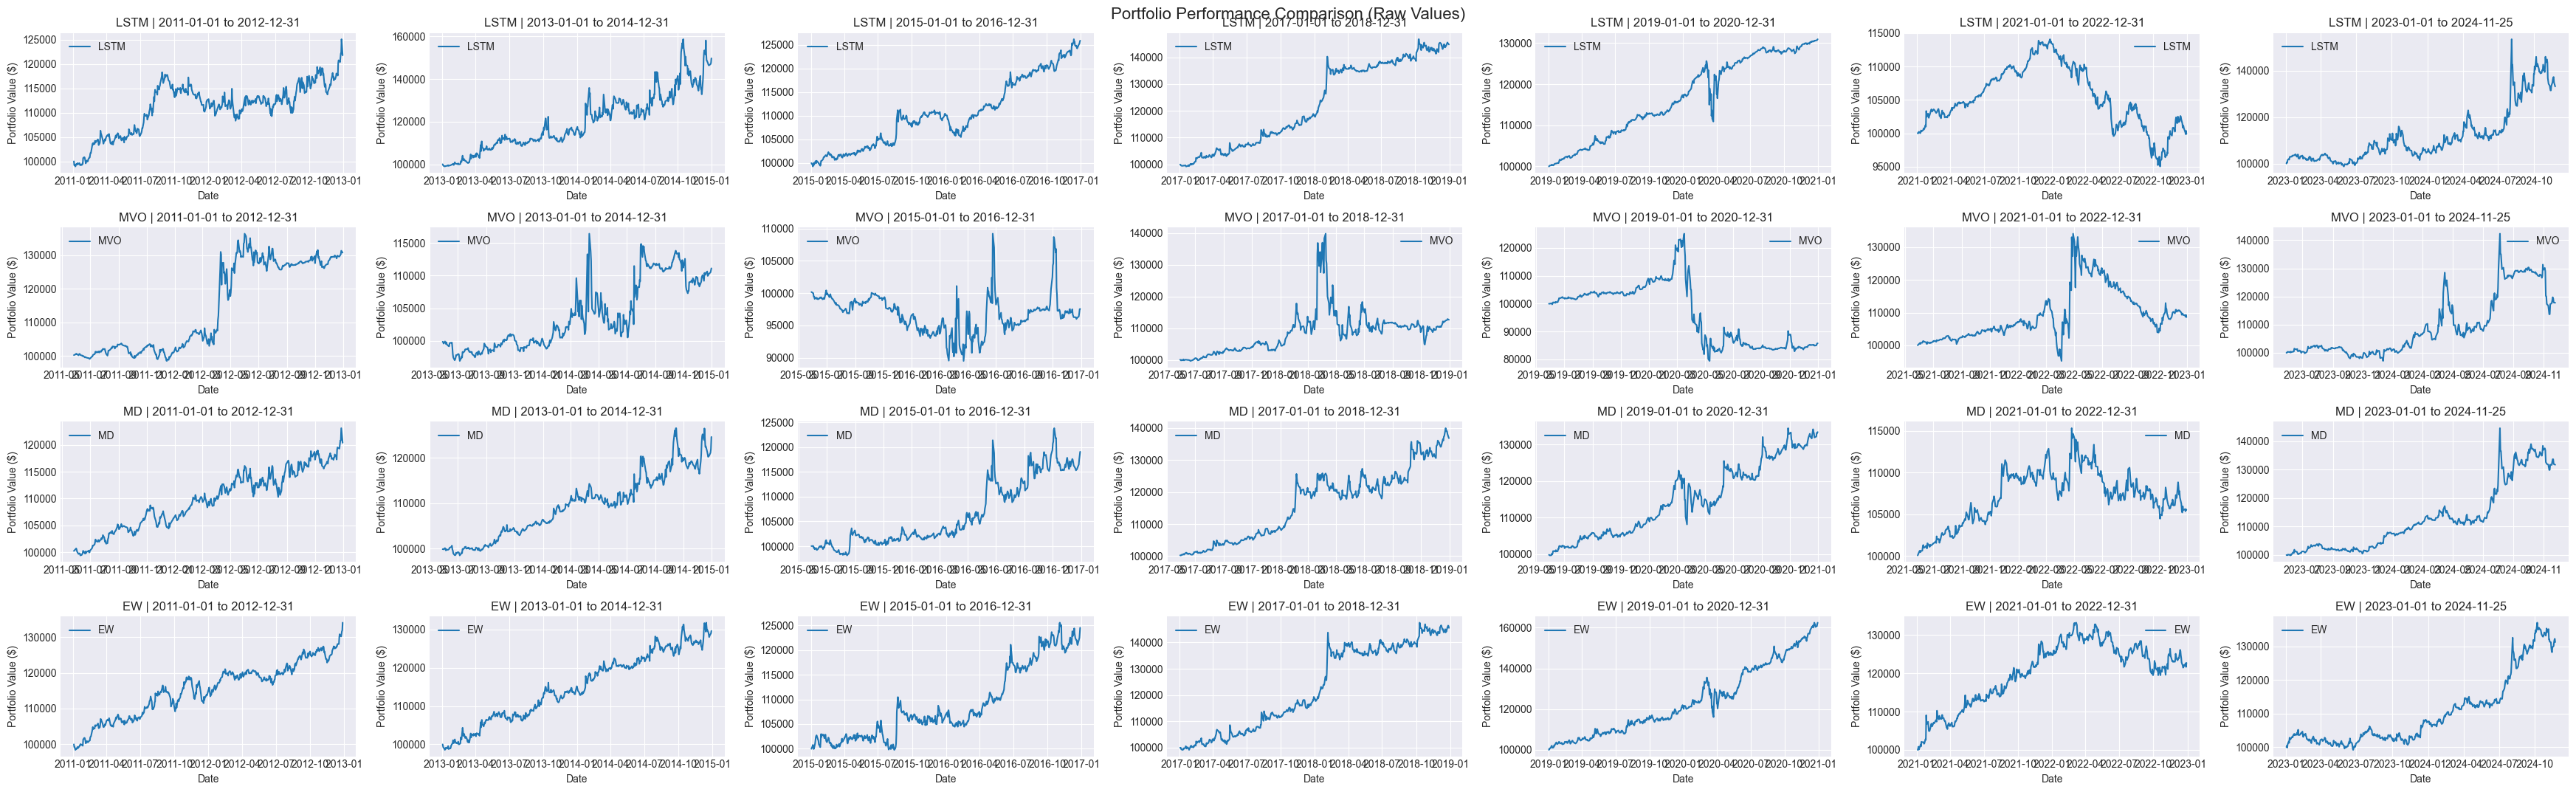


Testing period: 2011-01-01 to 2012-12-31
LSTM Metrics:
{'Annualized Return': 0.10411236104685351, 'Annualized Std Dev': 0.11452153070881126, 'Sharpe Ratio': 0.9221133032660046, 'Sortino Ratio': 1.5540213943313388, 'Max Drawdown': 0.08417632839427773, '% Positive Returns': 50.29940119760479, 'Profit/Loss Ratio': 1.1579251903157006}
MVO Metrics:
{'Annualized Return': 0.1823243433381374, 'Annualized Std Dev': 0.19373249850650817, 'Sharpe Ratio': 0.9596688711707291, 'Sortino Ratio': 1.4587658689206442, 'Max Drawdown': 0.1097849796230944, '% Positive Returns': 50.74999999999999, 'Profit/Loss Ratio': 1.217312219785667}
MD Metrics:
{'Annualized Return': 0.12244586462582174, 'Annualized Std Dev': 0.10251634831083772, 'Sharpe Ratio': 1.1782264883165157, 'Sortino Ratio': 1.8179260591735749, 'Max Drawdown': 0.05006307613818067, '% Positive Returns': 53.25, 'Profit/Loss Ratio': 1.074688972429931}
EW Metrics:
{'Annualized Return': 0.1591787512940308, 'Annualized Std Dev': 0.09336067631926401, 'Sha

In [14]:
strategies = ['LSTM', 'MVO', 'MD', 'EW']
plot_performance_comparison(portfolio_histories, periods, strategies)
#Print metrics for each testing period
for i, period in enumerate(periods):
    training_end, testing_start, testing_end = period
    print(f"\nTesting period: {testing_start} to {testing_end}")
    print("LSTM Metrics:")
    print(lstm_metrics[i])
    print("MVO Metrics:")
    print(mvo_metrics[i])
    print("MD Metrics:")
    print(md_metrics[i])
    print("EW Metrics:")
    print(ew_metrics[i])


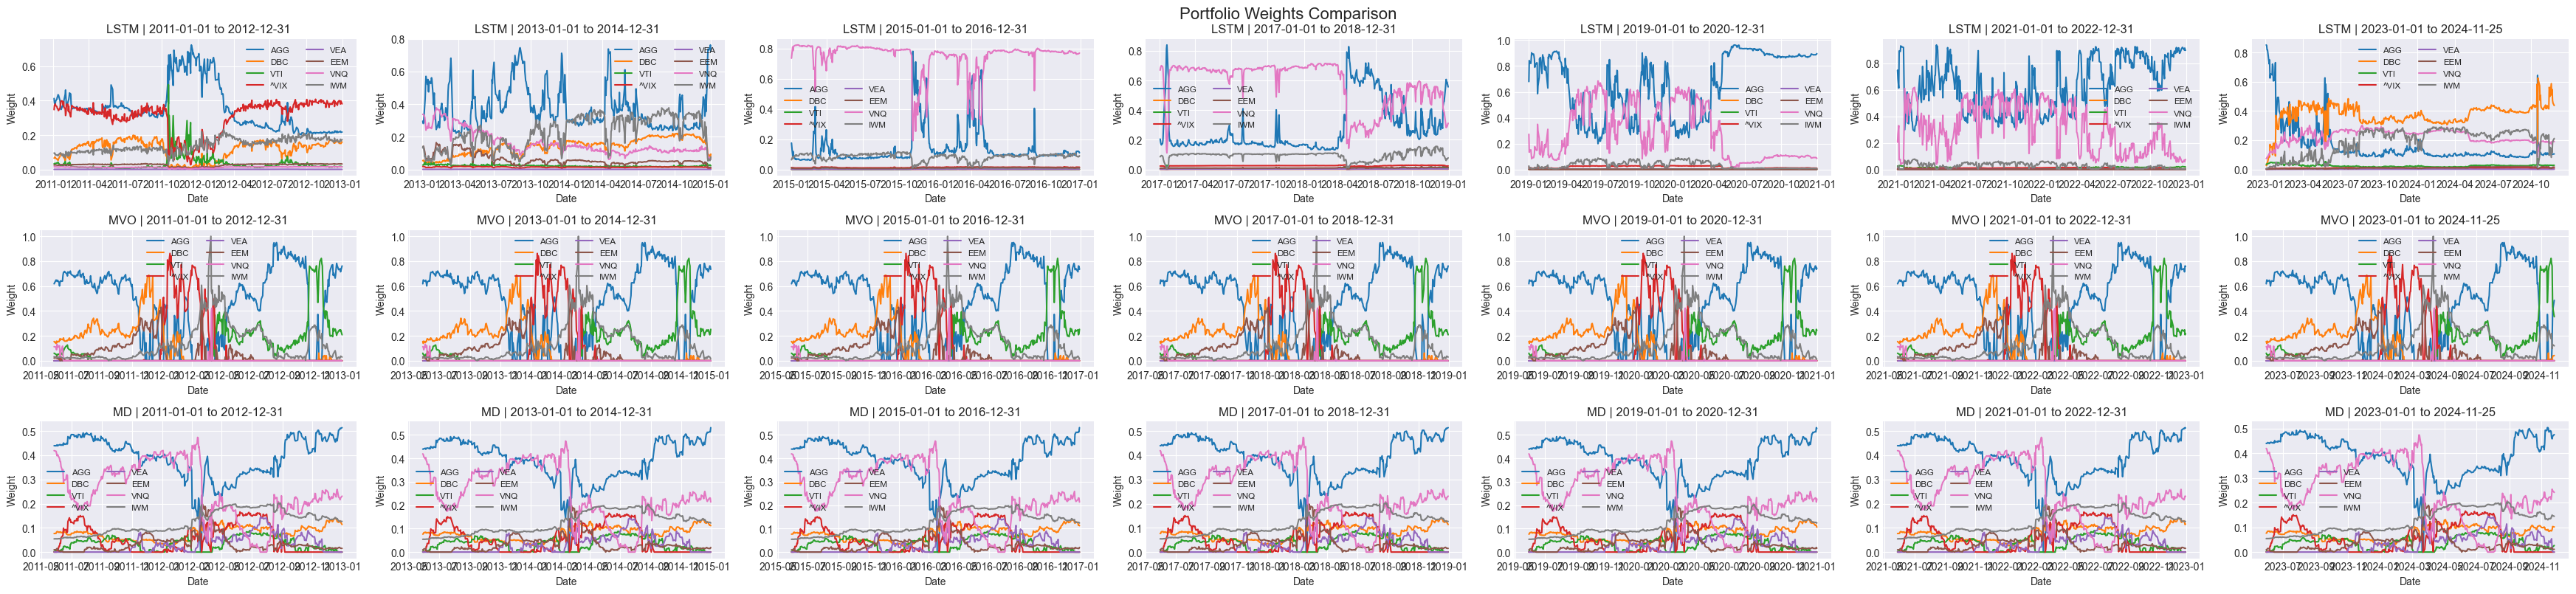

In [15]:
strategies = ['LSTM', 'MVO', 'MD']
asset_names = ['AGG', 'DBC', 'VTI', '^VIX', 'VEA', 'EEM', 'VNQ', 'IWM']
plot_weights_comparison(portfolio_histories, periods, strategies, asset_names)